# FER with the Vision Transformer (ViT)

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Clonning Dependencies

In [2]:
!pip install -q git+https://github.com/huggingface/transformers datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [3]:
from datasets import *
from transformers import ViTFeatureExtractor
from transformers import ViTModel
from transformers import TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Dependencies

In [4]:
string_labels = ['Happy', 'Sad']

In [5]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
fer_df = pd.read_csv('/content/drive/MyDrive/fer.csv')

In [8]:
fer_df.head()

,emotion,pixels
0,1,204 206 200 104 71 77 112 170 193 204 218 223 ...
1,1,19 21 27 28 33 29 41 37 24 31 42 45 48 62 63 7...
2,1,223 245 233 243 243 243 244 244 248 245 218 21...
3,1,119 30 120 166 119 101 108 91 51 58 68 82 100 ...
4,1,76 93 103 96 99 103 103 120 134 138 149 150 14...


## Split the data

In [9]:
X = fer_df['pixels']
y = fer_df['emotion']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.1, 
                                                    shuffle=True,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.1, 
                                                  random_state=42)

In [11]:
print(np.round(((X_train.shape[0]) / (X.shape[0]))*100), "% of Train set")
print(np.round(((X_val.shape[0]) / (X.shape[0]))*100), "% of Validation set")
print(np.round(((X_test.shape[0]) / (X.shape[0]))*100), "% of Test set")

81.0 % of Train set
9.0 % of Validation set
10.0 % of Test set


In [12]:
train_data = {'pixels': X_train, 'emotion': y_train}

train_df = pd.DataFrame(train_data)

In [13]:
val_data = {'pixels': X_val, 'emotion': y_val}

val_df = pd.DataFrame(val_data)

In [14]:
test_data = {'pixels': X_test, 'emotion': y_test}

test_df = pd.DataFrame(test_data)

## Preprocessing

### First preprocessing step

In [15]:
def prepare_fer_data(data):
    """ Prepare fer data for vision transformer 
        input: fer df loaded from csv
        output: df that can be load into a huggingface dataset """

    # outputs
    image_list = []
    image_labels = list(map(int, data['emotion']))
    
    # go over all images
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        # adapt grayscale to rgb format (change single values to triplets of the same value)
        image = image[..., np.newaxis]
        image = np.repeat(image, 3, axis=2)
        # convert to list format used by the later functions
        image = image.astype(int).tolist()
        # save to output
        image_list.append(image)

    output_df = pd.DataFrame(list(zip(image_list, image_labels)),
               columns =['img', 'label'])
        
    return output_df

In [16]:
fer_train_df = prepare_fer_data(train_df)

fer_val_df = prepare_fer_data(val_df)

fer_test_df = prepare_fer_data(test_df)

In [17]:
fer_train_df.head()

,img,label
0,"[[[66, 66, 66], [72, 72, 72], [63, 63, 63], [7...",0
1,"[[[121, 121, 121], [113, 113, 113], [120, 120,...",1
2,"[[[40, 40, 40], [56, 56, 56], [74, 74, 74], [6...",1
3,"[[[29, 29, 29], [33, 33, 33], [28, 28, 28], [3...",0
4,"[[[191, 191, 191], [197, 197, 197], [196, 196,...",1


In [18]:
print(len(fer_train_df))
print(len(fer_test_df))
print(len(fer_val_df))

14562
1798
1618


In [19]:
#downsample the data for ram issues
print(len(fer_train_df[0:3000]))
print(len(fer_val_df[0:100]))
print(len(fer_test_df[0:100]))

3000
100
100


In [20]:
train_ds = Dataset.from_pandas(fer_train_df[0:3000])
val_ds = Dataset.from_pandas(fer_val_df[0:100])
test_ds = Dataset.from_pandas(fer_test_df[0:100])

In [21]:
np.array(train_ds[0]["img"]).shape

(48, 48, 3)

### Second preprocessing step using the ViT feature extractor

In [22]:
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    images = [np.array(image, dtype=np.uint8) for image in images]
    images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # preprocess and add pixel_values
    inputs = feature_extractor(images=images)
    examples['pixel_values'] = inputs['pixel_values']

    return examples

In [23]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=['Happy', 'Sad']),
    'img': Array3D(dtype="int64", shape=(3,48,48)),
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
})

In [24]:
preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, batch_size=1, features=features)
with open('preprocessed_train_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [25]:
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_val_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [26]:
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_test_ds.pickle', 'wb') as handle:
    pickle.dump(preprocessed_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [27]:
# final image size
print(len(preprocessed_train_ds[0]["pixel_values"]))       
print(len(preprocessed_train_ds[0]["pixel_values"][0]))     
print(len(preprocessed_train_ds[0]["pixel_values"][0][0]))  

3
224
224


## Data Viz

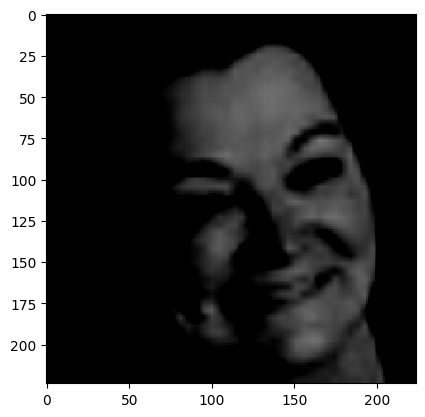

Happy


In [28]:
# show a single image from the dataset
data_for_image = np.array(preprocessed_train_ds[0]["pixel_values"])
data_for_image[data_for_image < 0] = 0 

plt.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
plt.show()

print(string_labels[preprocessed_train_ds[0]["label"]])

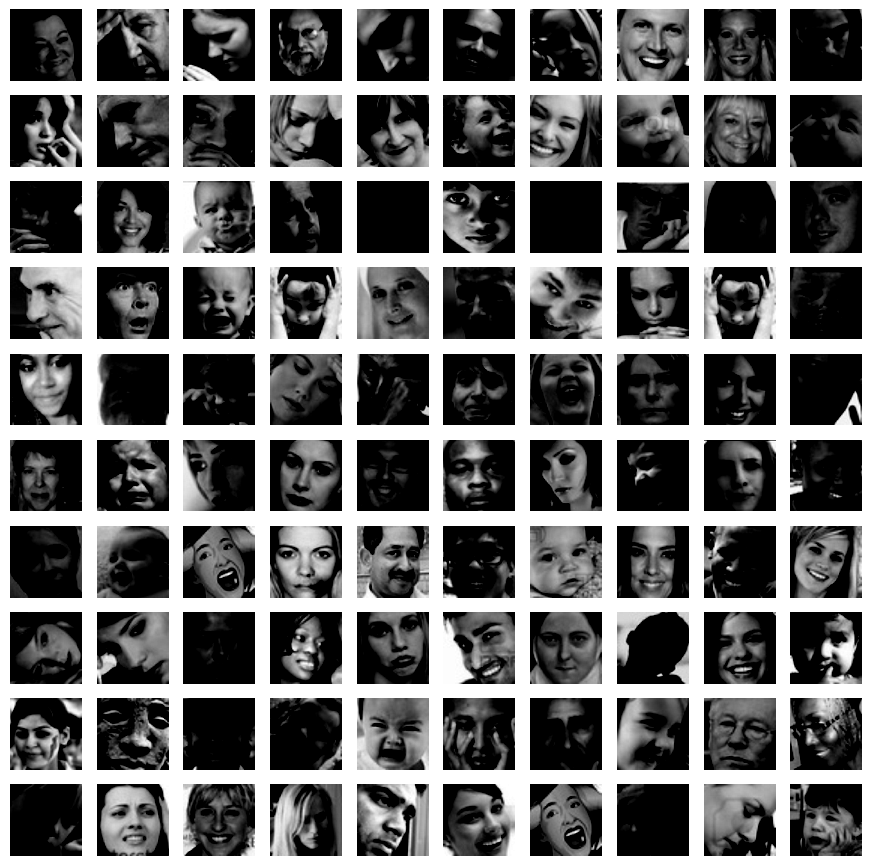

In [29]:
# show 100 images from the dataset
fig, axes = plt.subplots(10,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(preprocessed_train_ds[i]["pixel_values"])
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (1,2,0)), interpolation='nearest')
  ax.set_axis_off()


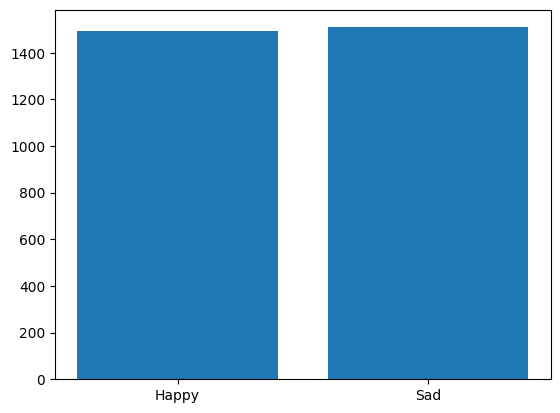

In [30]:
# distribution of labels in the training set
keys, counts = np.unique(preprocessed_train_ds["label"], return_counts=True)
plt.bar(string_labels, counts)
plt.show()

## Model

In [31]:
class ViTForImageClassification(nn.Module):
    #define architecture
    def __init__(self, num_labels=len(string_labels)):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    #define a forward pass through that architecture + loss computation
    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [35]:
metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
)

In [36]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-36-e0422430864c>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [37]:
model = ViTForImageClassification()

In [38]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = preprocessed_train_ds,
    eval_dataset = preprocessed_val_ds,
    compute_metrics = compute_metrics,
)

## Fine-tuning ViT

In [39]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.248020,0.890000
2,No log,0.119106,0.960000
3,0.202500,0.111253,0.950000
4,0.202500,0.121805,0.960000
5,0.202500,0.120732,0.950000
6,0.036800,0.119325,0.950000


TrainOutput(global_step=1128, training_loss=0.10820451230867535, metrics={'train_runtime': 1113.0194, 'train_samples_per_second': 16.172, 'train_steps_per_second': 1.013, 'total_flos': 0.0, 'train_loss': 0.10820451230867535, 'epoch': 6.0})

## Evaluation on Test Set

In [40]:
outputs = trainer.predict(preprocessed_test_ds)
print(outputs.metrics)

{'test_loss': 0.18136054277420044, 'test_accuracy': 0.92, 'test_runtime': 3.6465, 'test_samples_per_second': 27.423, 'test_steps_per_second': 1.92}


In [41]:
outputs.metrics

{'test_loss': 0.18136054277420044,
 'test_accuracy': 0.92,
 'test_runtime': 3.6465,
 'test_samples_per_second': 27.423,
 'test_steps_per_second': 1.92}

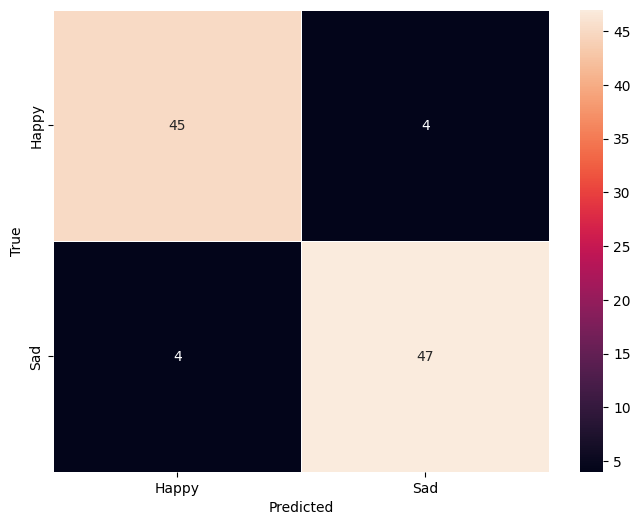

In [42]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

cm = confusion_matrix(y_true, y_pred)

# plot with seaborn
fig, ax = plt.subplots(figsize=(8,6))  
ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=string_labels, yticklabels=string_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [43]:
from sklearn.metrics import classification_report

print('Classification Report')
print(classification_report(y_true, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        49
           1       0.92      0.92      0.92        51

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



`ViT for FER`